# Stereo Template Matching/Block Matching

## Introduction:
Stereo matching is a technique used in computer vision to estimate the depth of objects in a scene. It relies on two images taken from slightly different perspectives, known as a stereo pair (left and right images). The goal is to compute a **disparity map**—a map that contains the difference in position of objects between the two images. This disparity map can then be used to infer the relative depth of objects in the scene.

In this exercise, we will use **Block Matching (BM)** to compute the disparity map between stereo images.

## Steps Involved:
1. **Grayscale Conversion**:
    - We first convert the stereo pair of images (left and right) into grayscale because the block matching algorithm works more efficiently on single-channel (grayscale) images.

2. **Stereo Block Matching (BM)**:
    - Block Matching is a technique where small blocks from the left image are compared with corresponding blocks from the right image to determine the disparity. The disparity is the horizontal shift between corresponding points in the two images. This shift can be used to compute the depth of objects in the scene.

3. **Disparity Map Computation**:
    - The disparity map is computed using the `cv2.StereoBM_create()` function in OpenCV. Several parameters affect the quality of the disparity map, which we can tune to improve results.

4. **Exporting to Point Cloud**:
    - Once a good disparity map is obtained, we can convert it into a 3D point cloud and save it as a `.ply` file. This file can be opened in a 3D visualization tool like **MeshLab** for visualization of the 3D scene.

---

## Key Parameters and Their Effects:

1. **min_disp**: 
   - **Description**: Minimum possible disparity value. It defines how far objects can shift between the left and right images.
   - **Typical Range**: 0 to 10.
   - **Effect**: Lower values focus on closer objects. Higher values skip nearby objects and focus on distant ones.

2. **num_disp**:
   - **Description**: Total disparity range considered. Must be divisible by 16.
   - **Typical Range**: 16, 32, 48, ..., typically in multiples of 16.
   - **Effect**: Higher values cover a larger depth range but increase computation time. Smaller values might miss depth information for distant objects.

3. **block_size**:
   - **Description**: Size of the blocks used for matching between the two images.
   - **Typical Range**: Odd numbers between 5 and 25 (e.g., 5, 7, 9, 11, 15, 21).
   - **Effect**: Larger block sizes provide smoother results but reduce detail. Smaller block sizes offer more detail but may introduce noise.

4. **setDisp12MaxDiff**:
   - **Description**: Maximum difference in disparity between left-right consistency check.
   - **Typical Range**: 0 to 250.
   - **Effect**: Lower values improve accuracy but can cause more rejected matches, while higher values make matching looser.

5. **UniquenessRatio**:
   - **Description**: Specifies how unique the best match should be compared to other matches.
   - **Typical Range**: 5 to 15.
   - **Effect**: Higher values enforce stricter matching (less noise), while lower values may increase noise.

6. **SpeckleRange**:
   - **Description**: Maximum disparity variation within connected components (speckle regions).
   - **Typical Range**: 0 to 50.
   - **Effect**: Lower values remove noise more aggressively, while higher values allow for more disparity variation in speckle regions.

7. **SpeckleWindowSize**:
   - **Description**: Size of the window used to remove speckle noise.
   - **Typical Range**: 0 to 200.
   - **Effect**: Larger values retain more valid points but may include noise, while smaller values clean up speckles more aggressively.

---

## Disparity Map and Point Cloud:
- Once a disparity map is computed, we can use it to generate a **point cloud**. The point cloud represents 3D positions of pixels from the original images, reconstructed using the disparity information.

- **Focal Length (f)**: This is a guess for the focal length of the camera. Adjusting this parameter can affect the perceived depth in the 3D visualization. It is calculated based on the image width as `f = 0.8 * image width`.

- **Baseline**: The distance between the two cameras. This value affects the scale of the 3D reconstruction. In the point cloud creation step, a baseline is approximated as `5%` of the image width.

---

## Exporting to PLY File:
- We export the computed 3D points into a **PLY** file using the `cv2.reprojectImageTo3D()` function. This file can be opened in tools like **MeshLab** to visualize the 3D scene.

```python
def export_pointcloud(disparity_map, colors):
    # Point cloud export function
    pass


In [84]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import data

plt.gray()

<Figure size 640x480 with 0 Axes>

Start by loading a set of corresponding left and right image. We also resize the images since the computations we expect to do can take a long time to process. Resizing is optional, but recommended atleast until you have verified your computer is capable of doing the computations within reasonable time.

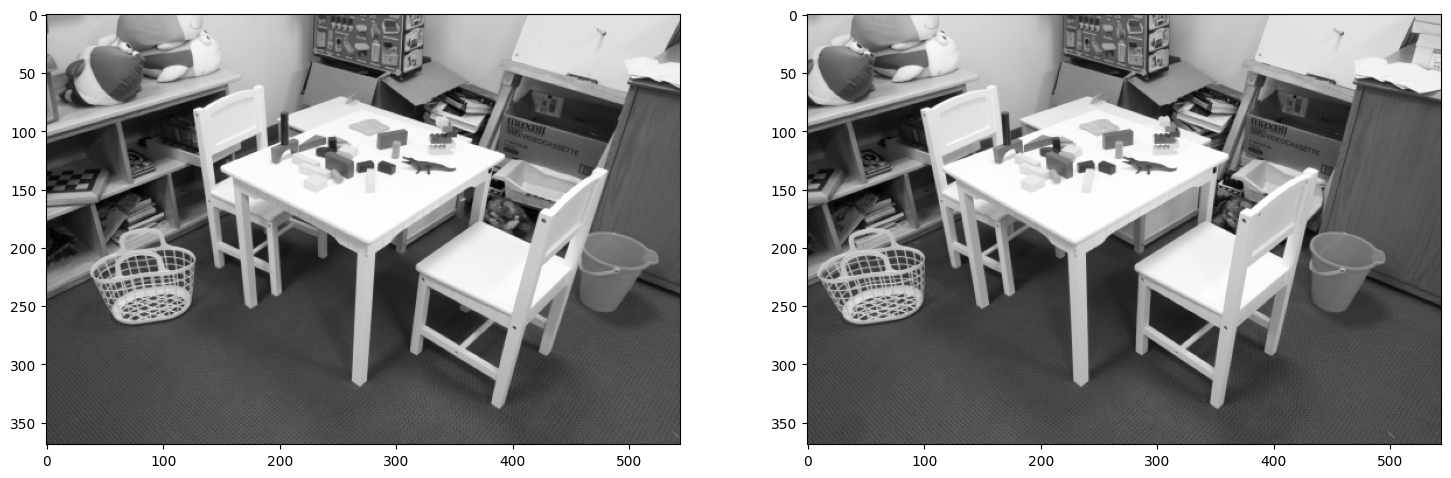

In [85]:
# load the images
img_left = cv2.imread("playtable_left.png")
img_right = cv2.imread("playtable_right.png")

# rescale images (can be left out)
img_size = (int(img_left.shape[1]/5), int(img_left.shape[0]/5))
img_left = cv2.resize(img_left, img_size, interpolation=cv2.INTER_AREA)
img_right = cv2.resize(img_right, img_size, interpolation=cv2.INTER_AREA)

# convert images to grayscale for template matching
gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

f, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(18,18))
ax_left.imshow(gray_left)
ax_right.imshow(gray_right)

Next step is to create a disparity map based on the two stereo images. This is done using the same procedure as we did with exercise 1, except now we look for blocks of pixel from the left image in the right image, or vice versa.

## Exercise 2.1
You will have to play with the below parameters until you find a good solution that gives a representative 3D projection. Reflect/search on what those parameters actually mean and how they influence the outcome.

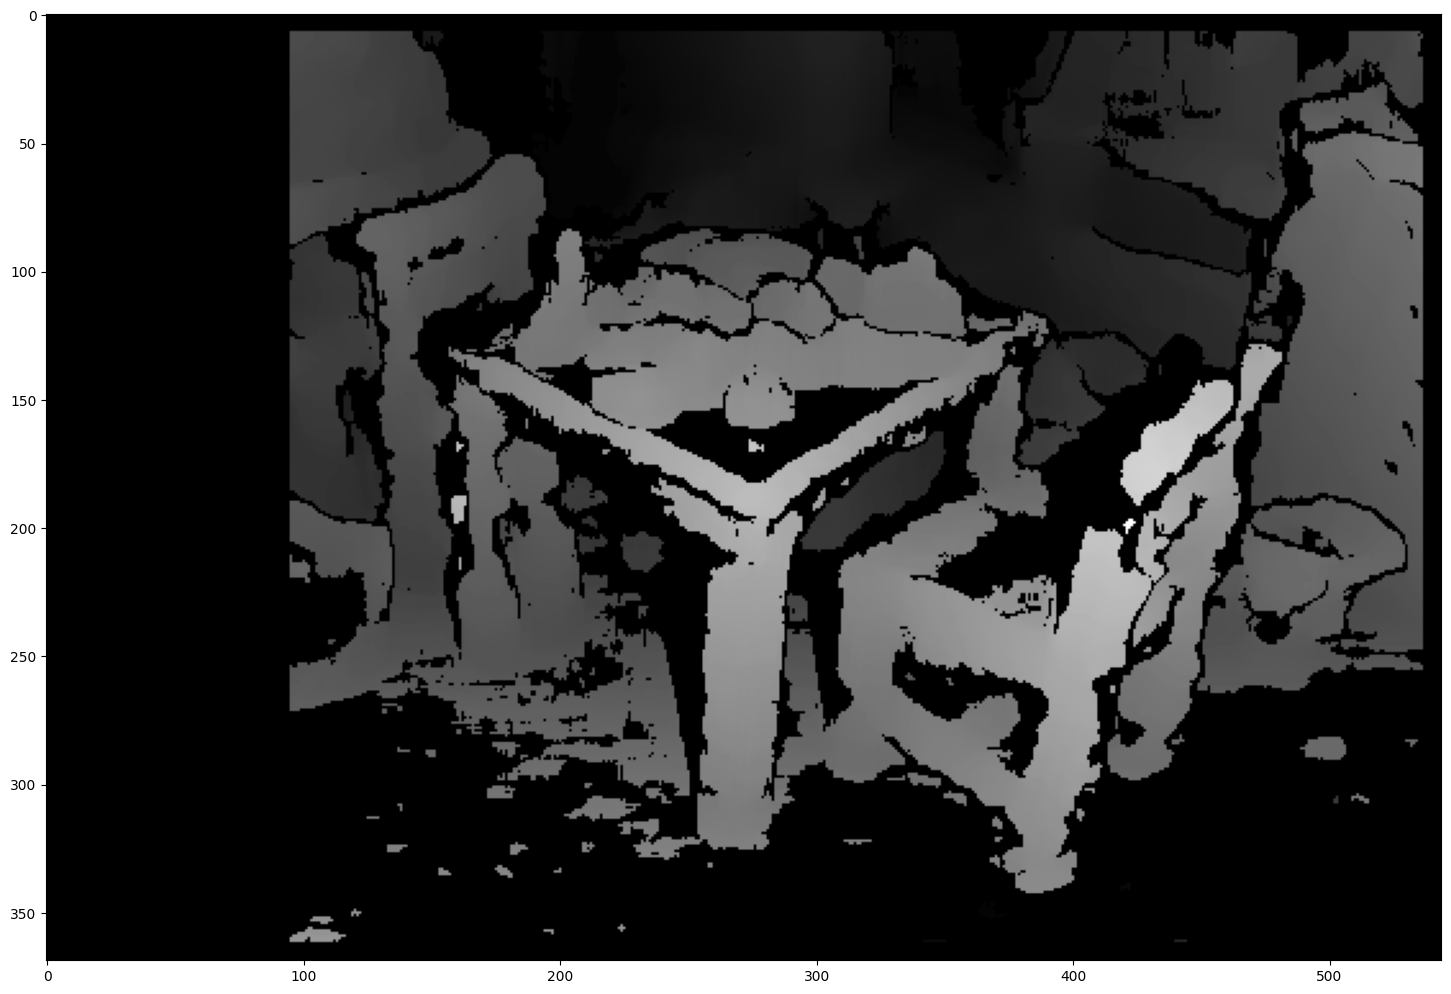

In [86]:
# Set parameters for the StereoBM algorithm
# StereoBM (Block Matching) is an algorithm to compute the disparity map
# The disparity map encodes the depth of objects in the scene

# Set parameters for the StereoBM algorithm
min_disp = 9  # Minimum disparity (how much the images can shift). Higher values focus on distant objects.
num_disp = 5 * 16  # Total disparity range. Must be divisible by 16. Higher values = larger depth range, but slower.
block_size = 15  # Size of blocks for matching. Larger values = smoother but less detailed. Smaller = more detail, more noise.

# Create the StereoBM object
stereo = cv2.StereoBM_create(numDisparities=num_disp, blockSize=block_size)

# Set additional fine-tuning parameters
stereo.setMinDisparity(min_disp)  # Sets the minimum disparity
stereo.setDisp12MaxDiff(100)  # Max difference between left and right disparities. Lower = more accurate, higher = looser.
stereo.setUniquenessRatio(20)  # How unique a match must be. Higher = stricter matching, lower = more noise.
stereo.setSpeckleRange(3)  # Max disparity variation in speckles (noise). Lower = more aggressive noise removal.
stereo.setSpeckleWindowSize(3)  # Size of noisy regions to be removed. Higher = keep more valid data but may retain noise.
disp = stereo.compute(gray_left, gray_right).astype(np.float32) / 16.0

plt.figure(figsize=(18,18))
plt.imshow(disp)

## Exercise 2.2
Once you have a disparity map without too much noise, you can use the below to export you disparity map to a .ply file that you can load and display in a 3D visualization software (e.g. [Meshlab](https://www.meshlab.net/#description)).

**Hint:** To open meshlab type `meshlab` in a terminal. 
To vizualize the point cloud, drag the generated `out.ply` into the meshlab scene or click `File` > `Import Mesh` and navigate to where our source-code is located and open `out.ply`. 

In [87]:
def export_pointcloud(disparity_map, colors):
    ply_header = '''ply
    format ascii 1.0
    element vertex %(vert_num)d
    property float x
    property float y
    property float z
    property uchar red
    property uchar green
    property uchar blue
    end_header
    '''

    def write_ply(fn, verts, colors):
        verts = verts.reshape(-1, 3)
        colors = colors.reshape(-1, 3)
        verts = np.hstack([verts, colors])
        with open(fn, 'wb') as f:
            f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
            np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

    h, w = disparity_map.shape[:2]
    f = .8 * w  # guess for focal length. If you 3D reconstruction looks skewed in the viewing direction, try adjusting this parameter.
    Q = np.float32([[1, 0, 0, -0.5 * w],
                    [0, -1, 0, 0.5 * h],  # turn points 180 deg around x-axis,
                    [0, 0, 0, -f],  # so that y-axis looks up
                    [0, 0, 1, 0]])
    points = cv2.reprojectImageTo3D(disparity_map, Q)
    
    mask = disparity_map > disparity_map.min()
    out_points = points[mask]
    out_colors = colors[mask]
    out_fn = 'out.ply'
    write_ply('out.ply', out_points, out_colors)
    print(f'{out_fn} saved')

export_pointcloud(disparity_map=disp, colors=img_left)

out.ply saved


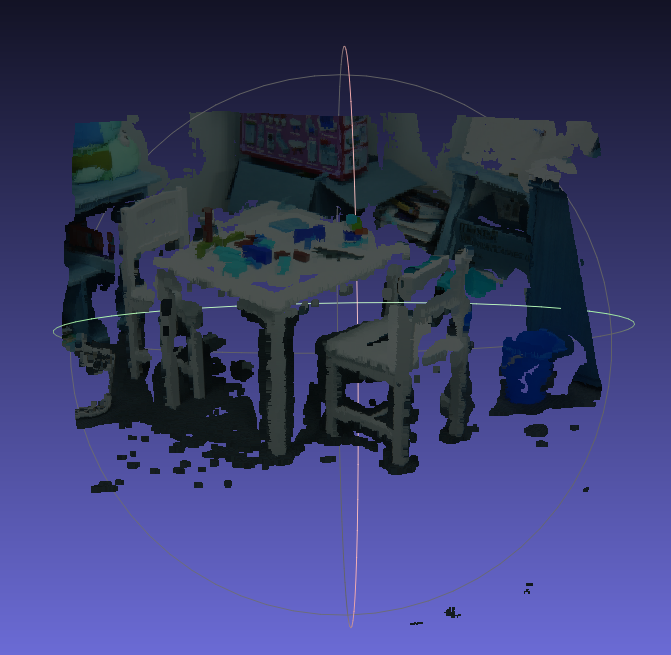

## Exercise 2.3

Create a disparity map of the imageset `storage` and display it in meshlab.

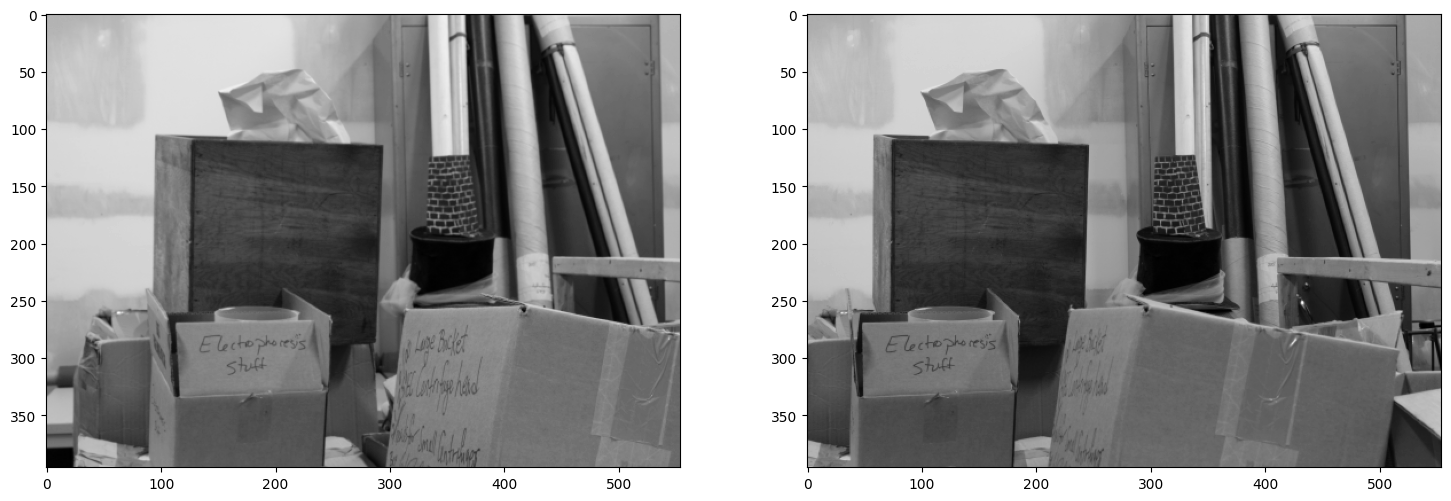

In [88]:
# load the images
img_left = cv2.imread("storage_left.png")
img_right = cv2.imread("storage_right.png")

# rescale images (can be left out)
img_size = (int(img_left.shape[1]/5), int(img_left.shape[0]/5))
img_left = cv2.resize(img_left, img_size, interpolation=cv2.INTER_AREA)
img_right = cv2.resize(img_right, img_size, interpolation=cv2.INTER_AREA)

# convert images to grayscale for template matching
gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

f, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(18,18))
ax_left.imshow(gray_left)
ax_right.imshow(gray_right)

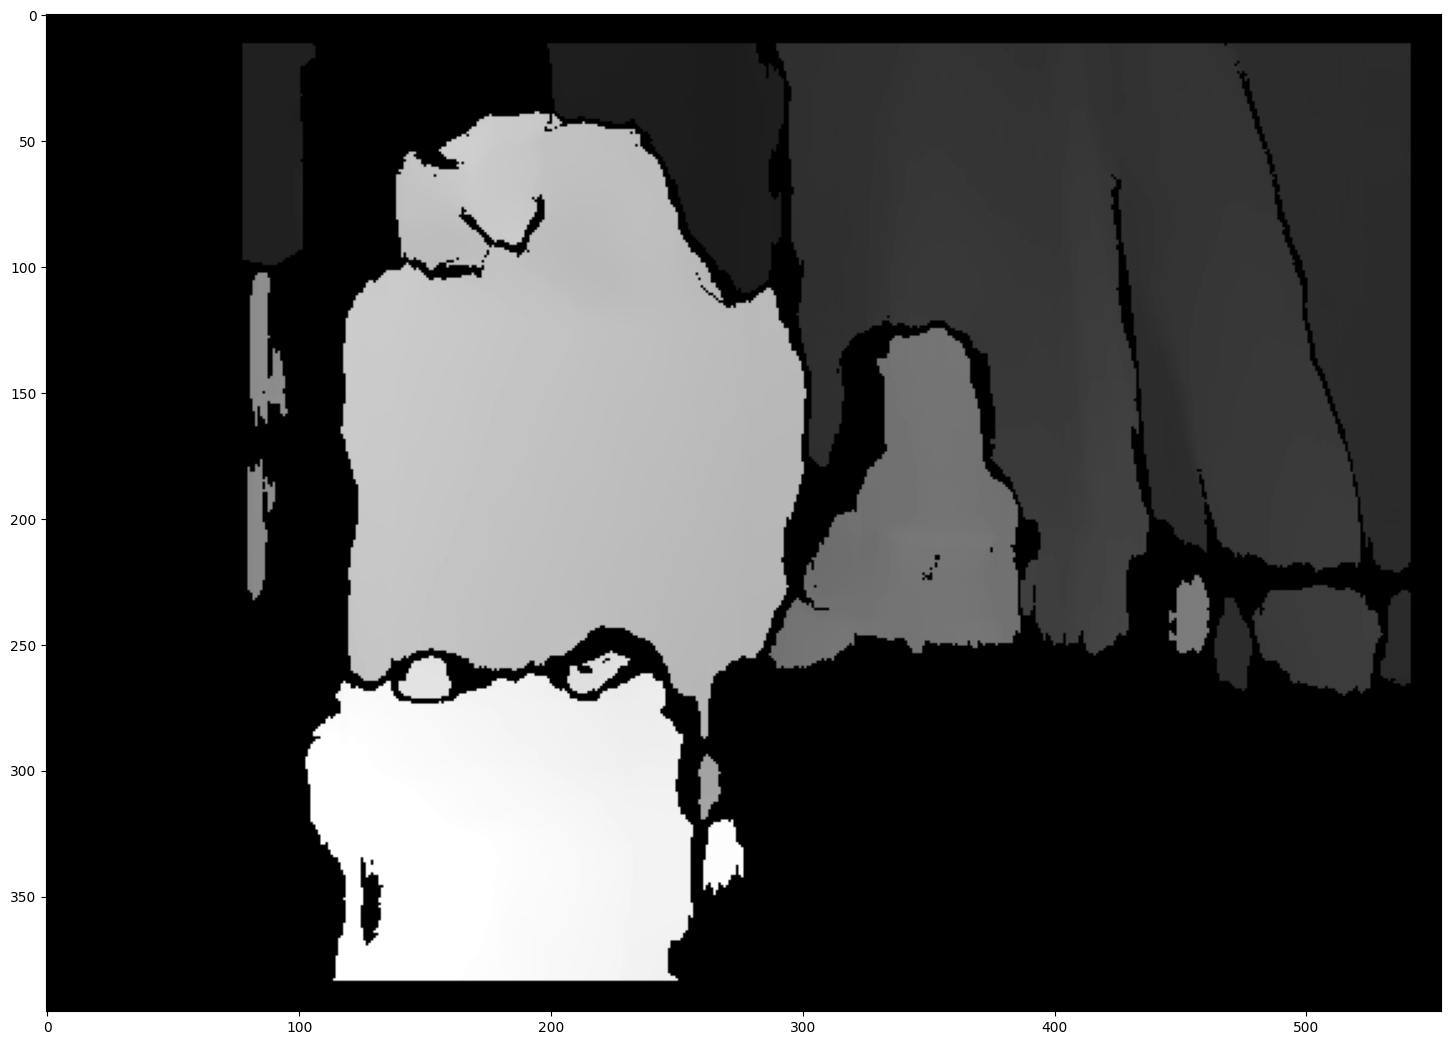

In [89]:
# Set parameters for the StereoBM algorithm
# StereoBM (Block Matching) is an algorithm to compute the disparity map
# The disparity map encodes the depth of objects in the scene

# Set parameters for the StereoBM algorithm
min_disp = 3  # Minimum disparity (how much the images can shift). Range: typically 0 to 10. Higher values focus on more distant objects.
num_disp = 0 * 16  # Total disparity range. Must be divisible by 16. Range: multiples of 16 (e.g., 16, 32, 48, ...). Higher values = larger depth range, but slower computation.
block_size = 25  # Size of blocks for matching. Range: odd numbers, typically 5 to 21. Larger values = smoother but less detailed. Smaller = more detail, more noise.

# Create the StereoBM object
stereo = cv2.StereoBM_create(numDisparities=num_disp, blockSize=block_size)

# Set additional fine-tuning parameters
stereo.setMinDisparity(min_disp)  # Sets the minimum disparity. Range: same as `min_disp` (e.g., 0 to 10)
stereo.setDisp12MaxDiff(5)  # Max difference between left and right disparities. Range: 0 to 250. Lower = more accurate, higher = looser and faster.
stereo.setUniquenessRatio(15)  # How unique a match must be. Range: 5 to 15 or more. Higher = stricter matching, lower = more noise allowed.
stereo.setSpeckleRange(5)  # Max disparity variation in speckles (noise). Range: 0 to 50. Lower = more aggressive noise removal.
stereo.setSpeckleWindowSize(150)  # Size of noisy regions to be removed. Range: 0 to 200. Higher = keep more valid data but may retain noise.

# Compute the disparity map
disp = stereo.compute(gray_left, gray_right).astype(np.float32) / 16.0  # Divide by 16 to scale the disparity map

# Display the disparity map
plt.figure(figsize=(18,18))
plt.imshow(disp)


In [90]:
import cv2
import numpy as np

def export_pointcloud(disparity_map, colors):
    ply_header = '''ply
    format ascii 1.0
    element vertex %(vert_num)d
    property float x
    property float y
    property float z
    property uchar red
    property uchar green
    property uchar blue
    end_header
    '''

    def write_ply(fn, verts, colors):
        verts = verts.reshape(-1, 3)
        colors = colors.reshape(-1, 3)
        verts = np.hstack([verts, colors])
        with open(fn, 'wb') as f:
            f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
            np.savetxt(f, verts, fmt='%f %f %f %d %d %d')

    # Adjust the focal length and Q matrix
    h, w = disparity_map.shape[:2]
    f = 0.8 * w  # Adjust the focal length, experiment with this value if needed
    baseline = 0.05 * w  # Approximation of the baseline distance between cameras

    # Q matrix for reprojecting disparity to 3D space
    Q = np.float32([[1, 0, 0, -0.5 * w],  # Shift x-coordinate to center the image
                    [0, -1, 0, 0.5 * h],  # Invert y-axis and center the image
                    [0, 0, 0, -f],        # Focal length along the z-axis
                    [0, 0, 1 / baseline, 0]])  # Adjust for baseline distance

    # Reproject disparity to 3D points
    points = cv2.reprojectImageTo3D(disparity_map, Q)

    # Create a mask to filter out invalid points
    mask = disparity_map > disparity_map.min()

    # Filter points and colors
    out_points = points[mask]
    out_colors = colors[mask]

    # Save the point cloud to a PLY file
    out_fn = 'out.ply'
    write_ply(out_fn, out_points, out_colors)
    print(f'{out_fn} saved')



In [91]:
export_pointcloud(disparity_map=disp, colors=img_left)

out.ply saved


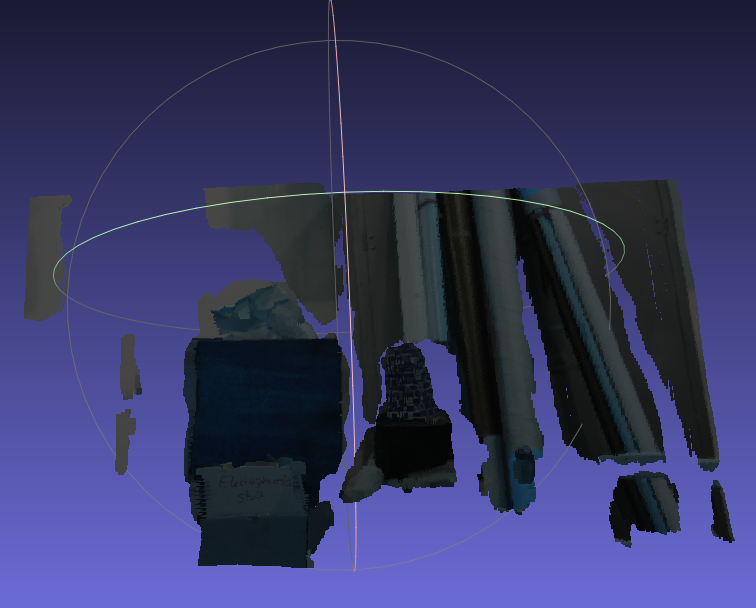